In [2]:
!pip install datasets transformers==4.51.3 nltk evaluate tqdm
!pip install bert_score


In [60]:
!pip install wandb

In [3]:
from tqdm import tqdm
import sys
import os
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import corpus_bleu
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("blue_score.ipynb"), "..")))
from datasets import load_dataset

# from transformers_models.marian.marianMT import


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
import random
import numpy as np

In [5]:
SEED_VALUE = 42


random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

In [5]:

#def retrieve_data():
#    dataset = load_dataset("wmt14", "de-en")
#
#    subset = dataset["train"].select(range(120000))
#
#    # train_data = subset.select(range(100000))
#    # val_data = subset.select(range(100000, 110000))
#    # test_data = subset.select(range(110000, 120000))
#
#
#
#    train_data = subset.select(range(15000))
#    val_data = subset.select(range(15000, 16000))
#    test_data = subset.select(range(16000, 17000))
#    return {
#        "train": train_data,
#        "validation": val_data,
#        "test": test_data
#    }


In [6]:
def retrieve_data(max_length=30):
    dataset = load_dataset("wmt14", "de-en")

    raw_subset = dataset["train"].select(range(200000))

    def is_short(example):
        return len(example["translation"]["de"].split()) <= max_length and \
               len(example["translation"]["en"].split()) <= max_length

    filtered = raw_subset.filter(is_short)

    train_data = filtered.select(range(15000))
    val_data = filtered.select(range(15000, 16000))
    test_data = filtered.select(range(16000, 17000))

    return {
        "train": train_data,
        "validation": val_data,
        "test": test_data
    }

In [7]:
def translated(n, model):
    return model.translate_text(n)

In [8]:

data = retrieve_data()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
print(data["train"].shape)
print(data["test"].shape)
print(data["validation"].shape)

(15000, 1)
(1000, 1)
(1000, 1)


In [10]:
data["validation"]["translation"][:10]

[{'de': 'Ihre Ablehnung wäre ein deutliches Zeichen für die Bürger, wäre eine verantwortliche Haltung des Parlaments.',
  'en': 'Rejecting it would represent a strong message to our citizens and a responsible attitude adopted by Parliament.'},
 {'de': 'Das ist Sinn und Zweck unseres Änderungsantrags, denn sonst muß man sich fragen, wann kommt der Wein ohne Trauben und die Butter ohne Sahne?',
  'en': 'This is the thrust of our amendment. If not, when will we see wine made without grapes and butter without cream?'},
 {'de': 'Trifft das denn auch so zu?', 'en': 'But is this actually true?'},
 {'de': 'Ich beginne mit der Verbraucherinformation.',
  'en': 'I will start with the information for the consumer.'},
 {'de': 'Die Kommission hat selbst zugegeben, daß es kein überzeugendes Nachweisverfahren gibt.',
  'en': 'The Commission has freely admitted that there is no foolproof detection method.'},
 {'de': 'Die Fehlerquote liegt bei 2 %.', 'en': 'The margin of error is 2%.'},
 {'de': 'Auf 5 

In [11]:
data["test"]["translation"][:10]

[{'de': 'Uns stimmt auch zufrieden, daß der Vorschlag den Dienstleistungsbereich einbezieht.',
  'en': 'We are also pleased that the proposal is to cover the service sector, too.'},
 {'de': 'Herr Präsident, als ich neulich bei meiner Schwägerin war, stellte ich fest, daß sie eine Flasche mit "umweltfreundlichem " Spülmittel hatte.',
  'en': 'Mr President, whilst recently at my sister-in-law\'s house, I noticed that she had a container of "eco-friendly" washing-up liquid.'},
 {'de': 'Die Moral der Geschichte besteht natürlich darin, daß umweltfreundliche Produkte möglichst ebenso leistungsfähig sein müssen wie Alternativerzeugnisse, wenn sie sich auf dem regulären Markt behaupten sollen.',
  'en': 'The moral of this story is, of course, that to compete in the mainstream market, eco-products must give a performance close to their alternatives.'},
 {'de': 'Nur dann werden diese Produkte in der Lage sein, den Sprung vom Nischenmarkt zum regulären Markt zu schaffen.',
  'en': 'Only then can

In [12]:
data["train"]["translation"][:10]

[{'de': 'Wiederaufnahme der Sitzungsperiode',
  'en': 'Resumption of the session'},
 {'de': 'Im Parlament besteht der Wunsch nach einer Aussprache im Verlauf dieser Sitzungsperiode in den nächsten Tagen.',
  'en': 'You have requested a debate on this subject in the course of the next few days, during this part-session.'},
 {'de': 'Ich bitte Sie, sich zu einer Schweigeminute zu erheben.',
  'en': "Please rise, then, for this minute' s silence."},
 {'de': '(Das Parlament erhebt sich zu einer Schweigeminute.)',
  'en': "(The House rose and observed a minute' s silence)"},
 {'de': 'Frau Präsidentin, zur Geschäftsordnung.',
  'en': 'Madam President, on a point of order.'},
 {'de': 'Wie Sie sicher aus der Presse und dem Fernsehen wissen, gab es in Sri Lanka mehrere Bombenexplosionen mit zahlreichen Toten.',
  'en': 'You will be aware from the press and television that there have been a number of bomb explosions and killings in Sri Lanka.'},
 {'de': 'Ja, Herr Evans, ich denke, daß eine derart

In [13]:
from transformers import MarianMTModel, MarianTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

model_name = "Helsinki-NLP/opus-mt-en-de"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [14]:
english = [n["en"] for n in data["train"]["translation"]]
german = [n["de"] for n in data["train"]["translation"]]

In [98]:
data

,Metric,Score
0,BLEU,0.244409
1,METEOR,0.515060
2,Precision(BERT),0.858005
3,Recall(BERT),0.855683
4,F1(BERT),0.856573


In [18]:
def preprocess(batch):
    src_texts = [ex["en"] for ex in batch["translation"]]
    tgt_texts = [ex["de"] for ex in batch["translation"]]

    model_inputs = tokenizer(
        src_texts,
        truncation=True,
        padding="max_length",
        max_length=40
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            tgt_texts,
            truncation=True,
            padding="max_length",
            max_length=40
        )["input_ids"]

    labels = [
        [(token if token != tokenizer.pad_token_id else -100) for token in seq]
        for seq in labels
    ]

    model_inputs["labels"] = labels
    return model_inputs


In [19]:
tokenized_data = {
    "train": data["train"].map(preprocess, batched = True),
    "validation": data["validation"].map(preprocess, batched=True)
}


Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [21]:
from tqdm import tqdm
import evaluate

bleu = evaluate.load("bleu")
test_subset = data["test"].select(range(1000))

src_texts = [ex["translation"]["en"] for ex in test_subset]
references = [[ex["translation"]["de"]] for ex in test_subset]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
batch_size = 16
predictions = []

for i in tqdm(range(0, len(src_texts), batch_size), desc="Translating"):
    batch = src_texts[i:i + batch_size]
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=60)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(**inputs, num_beams=4, max_length=60, early_stopping=True)
    preds = tokenizer.batch_decode(outputs, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    predictions.extend(preds)


Translating: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]


In [22]:
references[:10]

[['Uns stimmt auch zufrieden, daß der Vorschlag den Dienstleistungsbereich einbezieht.'],
 ['Herr Präsident, als ich neulich bei meiner Schwägerin war, stellte ich fest, daß sie eine Flasche mit "umweltfreundlichem " Spülmittel hatte.'],
 ['Die Moral der Geschichte besteht natürlich darin, daß umweltfreundliche Produkte möglichst ebenso leistungsfähig sein müssen wie Alternativerzeugnisse, wenn sie sich auf dem regulären Markt behaupten sollen.'],
 ['Nur dann werden diese Produkte in der Lage sein, den Sprung vom Nischenmarkt zum regulären Markt zu schaffen.'],
 ['Dem Umweltzeichen darf keine Mittelmäßigkeit anhaften.'],
 ['Der blaue Engel in Deutschland und der Schwan in Skandinavien waren Wegbereiter auf diesem Gebiet.'],
 ['Wir würden das Kind mit dem Bade ausschütten, wenn wir diese erfolgreichen Programme jetzt abschaffen würden.'],
 ['Langfristig ist ein einziges europäisches Umweltzeichen meiner Ansicht nach von Vorteil, es sollte jedoch niemandem aufgezwungen werden, der bereit

In [23]:
predictions[:10]

['Wir freuen uns auch, dass der Vorschlag auch für den Dienstleistungssektor gilt.',
 'Herr Präsident, während ich kürzlich im Haus meiner Schwägerin war, bemerkte ich, dass sie einen Behälter mit "umweltfreundlicher" Spülflüssigkeit hatte.',
 'Die Moral dieser Geschichte ist natürlich, dass Öko-Produkte, um auf dem Mainstream-Markt zu konkurrieren, eine Leistung in der Nähe ihrer Alternativen liefern müssen.',
 'Erst dann können diese Produkte aus dem Nischenmarkt, den sie bereits haben, in den Mainstream übergehen.',
 'Das Umweltzeichen sollte nicht mit Mittelmäßigkeit in Verbindung gebracht werden.',
 'Der deutsche Blaue Engel und der nordische Schwan haben den Weg in das Umweltzeichen geebnet.',
 'Um diese erfolgreichen Pläne jetzt zu beseitigen, wäre es, das Baby mit dem Badewasser wegzuwerfen.',
 'Langfristig sehe ich die Vorzüge des einheitlichen europäischen Umweltzeichens, aber das darf nicht denjenigen auferlegt werden, die bereits bestehende Systeme haben.',
 'Die Öko-Kennze

In [27]:
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [136]:
bleu_score = bleu.compute(predictions=predictions, references=references)
meteor_score = meteor.compute(predictions=predictions, references=[r[0] for r in references])
bert_score = bertscore.compute(predictions=predictions, references=[r[0] for r in references], lang="de")


In [137]:
bleu_score_BEFORE = bleu_score
meteor_score_BEFORE = meteor_score
bert_score_BEFORE = bert_score

In [138]:


print(f"BLEU before fine-tunning score: {bleu_score['bleu']:.4f}")

print("METEOR:", meteor_score["meteor"])
print("BERTScore:")
bert_precision = sum(bert_score['precision']) / len(bert_score['precision']) # TP/(TP+FP)
bert_recall = sum(bert_score['recall']) / len(bert_score['recall']) # TP/(TP+FN)
bert_f1 = sum(bert_score['f1']) / len(bert_score['f1'])
print(f"  Precision: {bert_precision:.4f}")
print(f"  Recall:    {bert_recall:.4f}")
print(f"  F1:        {bert_f1:.4f}")


BLEU before fine-tunning score: 0.1956
METEOR: 0.4509383611707493
BERTScore:
  Precision: 0.8324
  Recall:    0.8287
  F1:        0.8302


<ipython-input-48-fdf9445f8f9e>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Metric', y='Score', data=data, palette=palette)


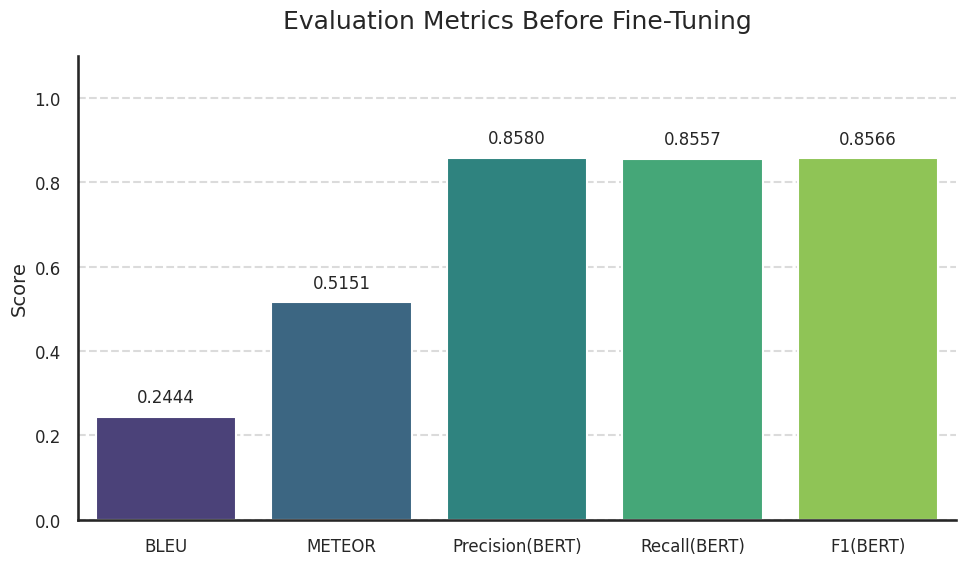

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



data = pd.DataFrame({
    'Metric': ['BLEU', 'METEOR', 'Precision(BERT)', 'Recall(BERT)', 'F1(BERT)'],
    'Score': [bleu_score['bleu'], meteor_score["meteor"], bert_precision, bert_recall, bert_f1]
})

sns.set(style="white", context="talk")
palette = sns.color_palette("viridis", len(data))

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Metric', y='Score', data=data, palette=palette)

for i, row in data.iterrows():
    ax.text(i, row['Score'] + 0.025, f"{row['Score']:.4f}",
            ha='center', va='bottom',  fontsize=12)

plt.title("Evaluation Metrics Before Fine-Tuning", fontsize=18, pad=20)
plt.ylim(0, 1.1)
plt.ylabel("Score", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine()
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(58101, 512, padding_idx=58100)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(58101, 512, padding_idx=58100)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [91]:
from evaluate import load

bleu_metric = load("bleu")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    list_of_lists = [[lbl] for lbl in decoded_labels]
    flat_list= decoded_labels



    bleu = bleu_metric.compute(predictions=decoded_preds, references=list_of_lists)

    meteor_score = meteor.compute(predictions=decoded_preds, references=list_of_lists)

    bert_score = bertscore.compute(predictions=decoded_preds, references=flat_list, lang="de")
    bert_precision = sum(bert_score['precision']) / len(bert_score['precision']) # TP/(TP+FP)
    bert_recall = sum(bert_score['recall']) / len(bert_score['recall']) # TP/(TP+FN)
    bert_f1 = sum(bert_score['f1']) / len(bert_score['f1'])

    return {
        "bleu": bleu["bleu"],
        "meteor": meteor_score["meteor"],
        "bertscore_precision": bert_precision,
        "bertscore_recall": bert_recall,
        "bertscore_f1": bert_f1
    }


In [66]:
!pip install --upgrade transformers


In [68]:
import transformers
print(transformers.__version__)

4.51.3


In [71]:
import transformers
print(transformers.Seq2SeqTrainingArguments.__init__.__code__.co_varnames)



('self', 'output_dir', 'overwrite_output_dir', 'do_train', 'do_eval', 'do_predict', 'eval_strategy', 'prediction_loss_only', 'per_device_train_batch_size', 'per_device_eval_batch_size', 'per_gpu_train_batch_size', 'per_gpu_eval_batch_size', 'gradient_accumulation_steps', 'eval_accumulation_steps', 'eval_delay', 'torch_empty_cache_steps', 'learning_rate', 'weight_decay', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'max_grad_norm', 'num_train_epochs', 'max_steps', 'lr_scheduler_type', 'lr_scheduler_kwargs', 'warmup_ratio', 'warmup_steps', 'log_level', 'log_level_replica', 'log_on_each_node', 'logging_dir', 'logging_strategy', 'logging_first_step', 'logging_steps', 'logging_nan_inf_filter', 'save_strategy', 'save_steps', 'save_total_limit', 'save_safetensors', 'save_on_each_node', 'save_only_model', 'restore_callback_states_from_checkpoint', 'no_cuda', 'use_cpu', 'use_mps_device', 'seed', 'data_seed', 'jit_mode_eval', 'use_ipex', 'bf16', 'fp16', 'fp16_opt_level', 'half_precision_backend',

In [92]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./marianmt-finetuned",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    num_train_epochs=7,
    eval_strategy="epoch",
    save_strategy="epoch",
    predict_with_generate=True,
    logging_dir="./logs",
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    logging_steps=500,
    load_best_model_at_end=True,
    #metric_for_best_model="bleu",
    #greater_is_better=True
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [85]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [93]:
from transformers import Seq2SeqTrainer, DataCollatorForSeq2Seq
from transformers import EarlyStoppingCallback

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
    compute_metrics=compute_metrics,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],

)

trainer.train()


<ipython-input-93-19d01fd8c734>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss,Bleu,Meteor,Bertscore Precision,Bertscore Recall,Bertscore F1
1,0.261100,2.833985,0.199907,0.468140,0.834203,0.830444,0.832019
2,0.443200,2.627028,0.193279,0.464987,0.832729,0.829945,0.831006
3,0.280300,2.698684,0.193420,0.460976,0.832422,0.829380,0.830563


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.encoder.embed_positions.weight', 'model.decoder.embed_tokens.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].


TrainOutput(global_step=11250, training_loss=0.29335560709635417, metrics={'train_runtime': 1457.277, 'train_samples_per_second': 72.052, 'train_steps_per_second': 18.013, 'total_flos': 476695756800000.0, 'train_loss': 0.29335560709635417, 'epoch': 3.0})

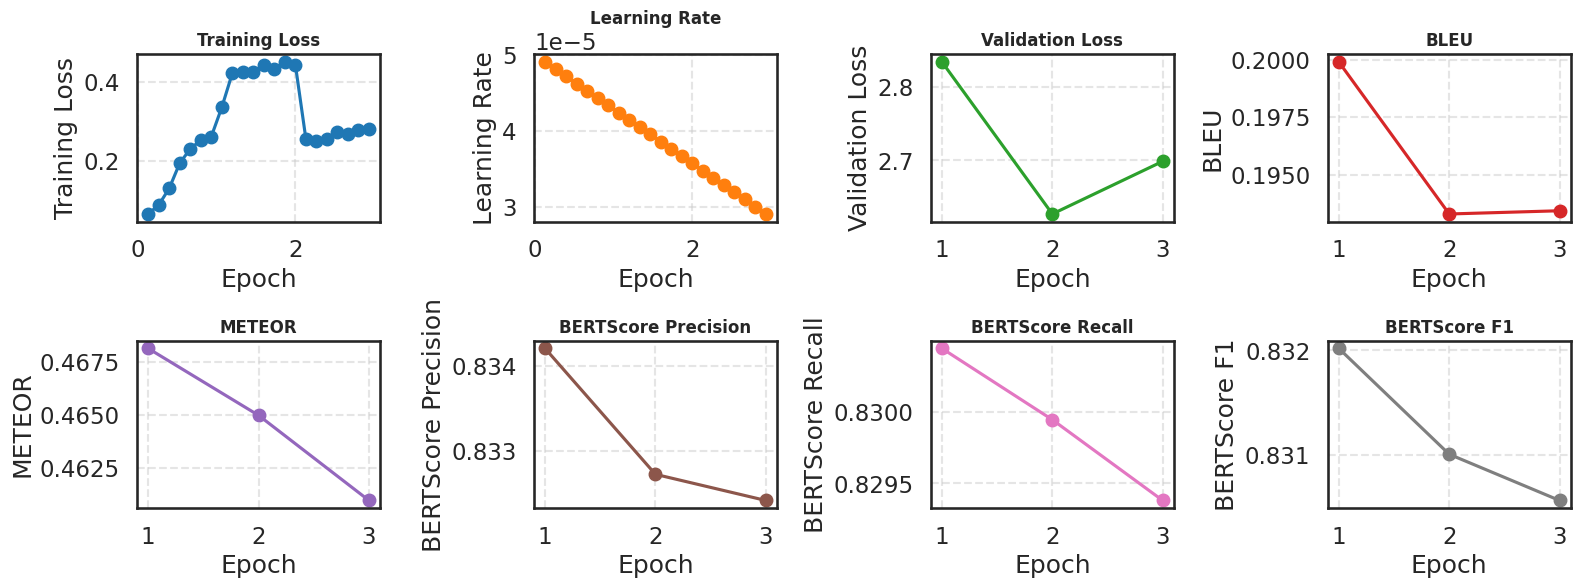

In [116]:
import matplotlib.pyplot as plt
import math

log_history   = trainer.state.log_history
epoch_entries = [e for e in log_history if "epoch" in e]

metrics = [
    "loss",
    "learning_rate",
    "eval_loss",
    "eval_bleu",
    "eval_meteor",
    "eval_bertscore_precision",
    "eval_bertscore_recall",
    "eval_bertscore_f1"
]
names = {
    "loss": "Training Loss",
    "learning_rate": "Learning Rate",
    "eval_loss": "Validation Loss",
    "eval_bleu": "BLEU",
    "eval_meteor": "METEOR",
    "eval_bertscore_precision": "BERTScore Precision",
    "eval_bertscore_recall": "BERTScore Recall",
    "eval_bertscore_f1": "BERTScore F1"
}

n = len(metrics)
cols = 4
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
axes = axes.flatten()

cmap = plt.get_cmap('tab10')

for i, metric in enumerate(metrics):
    ax = axes[i]
    currdata = [(e["epoch"], e[metric]) for e in epoch_entries if metric in e]
    if not currdata:
        ax.set_visible(False)
        continue
    epochs, values = zip(*currdata)

    ax.plot(epochs, values,
            marker='o',
            linestyle='-',
            color=cmap(i % 10),
            label=names.get(metric, metric))
    ax.set_title(names.get(metric, metric), fontsize=12, fontweight='bold')
    ax.set_xlabel("Epoch")
    ax.set_ylabel(names.get(metric, metric))
    ax.grid(linestyle='--', alpha=0.5)

for ax in axes[n:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


In [117]:
data = retrieve_data()
model = trainer.model
tokenizer = trainer.tokenizer

In [118]:
bleu = evaluate.load("bleu")
test_subset = data["test"].select(range(1000))

src_texts = [ex["translation"]["en"] for ex in test_subset]
references = [[ex["translation"]["de"]] for ex in test_subset]

batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
predictions = []

for i in tqdm(range(0, len(src_texts), batch_size), desc="Translating"):
    batch = src_texts[i:i + batch_size]
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=60)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=60, num_beams=4, early_stopping=True)
    preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    predictions.extend(preds)

Translating: 100%|██████████| 63/63 [00:40<00:00,  1.55it/s]


In [119]:
bleu_score = bleu.compute(predictions=predictions, references=references)
meteor_score = meteor.compute(predictions=predictions, references=[r[0] for r in references])
bert_score = bertscore.compute(predictions=predictions, references=[r[0] for r in references], lang="de")

In [130]:
bleu_score_AFTER = bleu_score
meteor_score_AFTER = meteor_score
bert_score_AFTER = bert_score

In [124]:
bert_precision = sum(bert_score['precision']) / len(bert_score['precision']) # TP/(TP+FP)
bert_recall = sum(bert_score['recall']) / len(bert_score['recall']) # TP/(TP+FN)
bert_f1 = sum(bert_score['f1']) / len(bert_score['f1'])

print(f"BLEU:   {bleu_score['bleu']:.4f}")
print(f"METEOR: {meteor_score['meteor']:.4f}")
print("BERTScore:")
print(f"  Precision: {bert_precision:.4f}")
print(f"  Recall:    {bert_recall:.4f}")
print(f"  F1:        {bert_f1:.4f}")

BLEU:   0.1956
METEOR: 0.4509
BERTScore:
  Precision: 0.8324
  Recall:    0.8287
  F1:        0.8302


<ipython-input-125-838f7e701cb1>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Metric', y='Score', data=data, palette=palette)


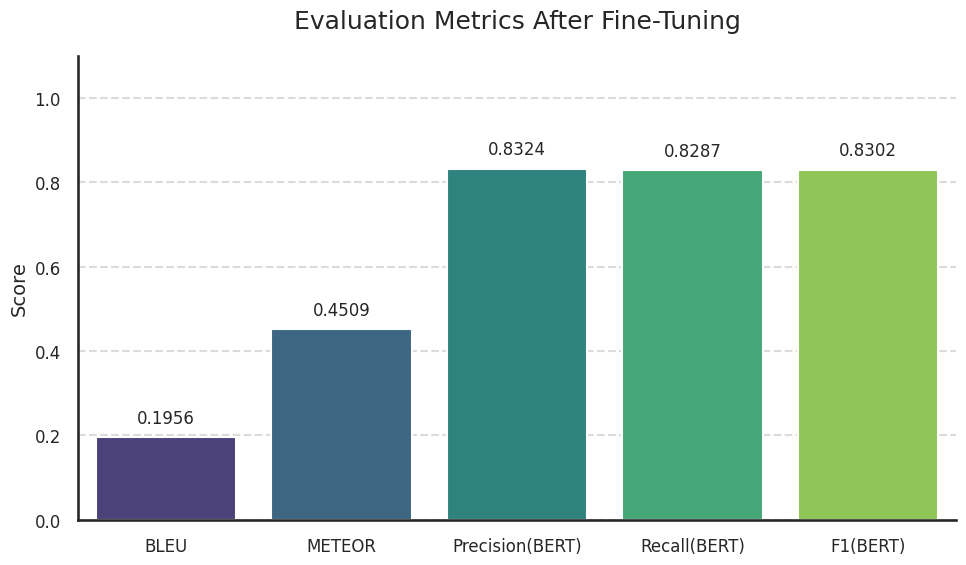

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



data = pd.DataFrame({
    'Metric': ['BLEU', 'METEOR', 'Precision(BERT)', 'Recall(BERT)', 'F1(BERT)'],
    'Score': [bleu_score['bleu'], meteor_score["meteor"], bert_precision, bert_recall, bert_f1]
})

sns.set(style="white", context="talk")
palette = sns.color_palette("viridis", len(data))

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Metric', y='Score', data=data, palette=palette)

for i, row in data.iterrows():
    ax.text(i, row['Score'] + 0.025, f"{row['Score']:.4f}",
            ha='center', va='bottom',  fontsize=12)

plt.title("Evaluation Metrics After Fine-Tuning", fontsize=18, pad=20)
plt.ylim(0, 1.1)
plt.ylabel("Score", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine()
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()


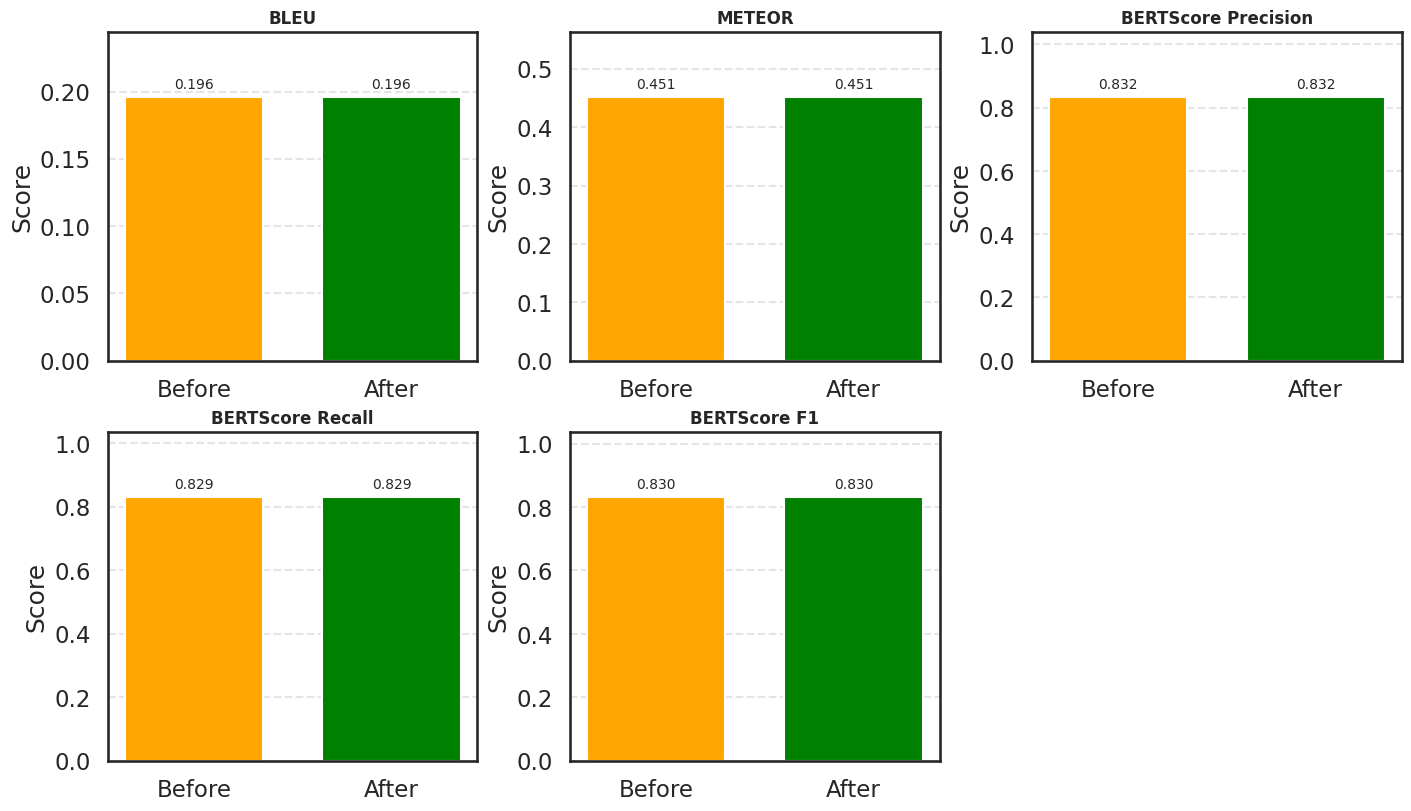

In [158]:
import numpy as np
import matplotlib.pyplot as plt

bleu_before= bleu_score_BEFORE["bleu"]
meteor_before= meteor_score_BEFORE["meteor"]
prec_before= np.mean(bert_score_BEFORE["precision"])
rec_before= np.mean(bert_score_BEFORE["recall"])
f1_before= np.mean(bert_score_BEFORE["f1"])

bleu_after     = bleu_score_AFTER["bleu"]
meteor_after   = meteor_score_AFTER["meteor"]
prec_after     = np.mean(bert_score_AFTER["precision"])
rec_after      = np.mean(bert_score_AFTER["recall"])
f1_after       = np.mean(bert_score_AFTER["f1"])

before = [bleu_before, meteor_before, prec_before, rec_before, f1_before]
after  = [bleu_after,  meteor_after,  prec_after,  rec_after,  f1_after]
metrics = [
    "BLEU",
    "METEOR",
    "BERTScore Precision",
    "BERTScore Recall",
    "BERTScore F1"
]

rows, cols = 2, 3
fig, axes = plt.subplots(
    rows, cols,
    figsize=(14, 8),
    constrained_layout=True
)
axes = axes.flatten()

for idx, ax in enumerate(axes):
    if idx < len(metrics):
        vals = [before[idx], after[idx]]
        ax.bar(
            ["Before", "After"],
            vals,
            color=["orange", "green"],
            width=0.7
        )
        ax.set_title(metrics[idx], fontsize=12, fontweight='bold')
        ax.set_ylabel("Score")
        ax.grid(axis='y', linestyle='--', alpha=0.5)

        top = max(vals) * 1.25
        ax.set_ylim(0, top)

        for i, v in enumerate(vals):
            ax.text(
                i, v + top * 0.02,
                f"{v:.3f}",
                ha='center',
                va='bottom',
                fontsize=10
            )
    else:
        ax.axis("off")



plt.show()


In [ ]:
model.save_pretrained("marianmt-finetuned")
tokenizer.save_pretrained("marianmt-finetuned")
